In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


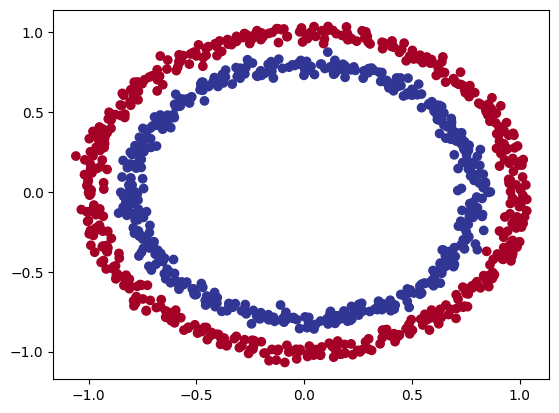

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

# Prepare data

## Convert NumPy data to tensors

In [5]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)



In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

# Building a model

1. Setting up a device agnostic code
2. Constructing a model by subclassing `nn.Module`
3. Defining a loss function and optimizer
4. Creating a training loop

In [7]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):

        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

It is possible to create the same model using `nn.Sequential`

In [9]:
model_0_s = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0_s

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
untrained_preds = model_0(X_test.to(device))
print("untrained predictions: ", untrained_preds[:10])
print("test labels: ", y_test[:10])


untrained predictions:  tensor([[-0.3614],
        [-0.1736],
        [-0.4852],
        [-0.3279],
        [ 0.1001],
        [ 0.2102],
        [ 0.2753],
        [ 0.3667],
        [-0.5097],
        [-0.1545]], device='cuda:0', grad_fn=<SliceBackward0>)
test labels:  tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Loss function and optimizer

In [11]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Evaluation metric

In [12]:
# number of correct predictions / total number of predictions
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Training

The model we've built only apply `nn.Linear()` so we still need to process the model's raw output for our classification problem. These raw outputs are called *logits.

In [13]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3614],
        [-0.1736],
        [-0.4852],
        [-0.3279],
        [ 0.1001]], device='cuda:0', grad_fn=<SliceBackward0>)

Now we use sigmoid activation function to get the desired form of outputs (sigmoid is used for binary classification problems). However, the resulf of `torch.sigmoid()` is the probability that the data example belongs to one of the classes (0 or 1)

In [14]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4106],
        [0.4567],
        [0.3810],
        [0.4188],
        [0.5250]], device='cuda:0', grad_fn=<SigmoidBackward0>)

We must now set a decision boundary to assign the label based on probability. For example, if we want to go with:
- If y_pred_probs >= 0.5, y=1 (class 1)
- If y_pred_probs < 0.5, y=0 (class 0)

We can round the values simply

In [15]:
y_preds = torch.round(y_pred_probs)

y_preds.squeeze()

tensor([0., 0., 0., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [16]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ## Training ##

    model_0.train()

    # Forward pass
    y_logits =  model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss/accuracy

    # nn.BCEWithLogitsLoss works with logits so we can pass them w/o having to apply sigmoid on them
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Zeroing optimizer
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    optimizer.step()

    ## Testing ##
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70812, Accuracy: 49.62% | Test loss: 0.71197, Test acc: 47.50%
Epoch: 10 | Loss: 0.70168, Accuracy: 49.00% | Test loss: 0.70597, Test acc: 49.50%
Epoch: 20 | Loss: 0.69841, Accuracy: 49.62% | Test loss: 0.70277, Test acc: 50.00%
Epoch: 30 | Loss: 0.69655, Accuracy: 50.62% | Test loss: 0.70083, Test acc: 49.50%
Epoch: 40 | Loss: 0.69540, Accuracy: 50.62% | Test loss: 0.69954, Test acc: 49.00%
Epoch: 50 | Loss: 0.69466, Accuracy: 50.75% | Test loss: 0.69862, Test acc: 49.00%
Epoch: 60 | Loss: 0.69416, Accuracy: 50.62% | Test loss: 0.69794, Test acc: 48.00%
Epoch: 70 | Loss: 0.69382, Accuracy: 50.50% | Test loss: 0.69742, Test acc: 48.50%
Epoch: 80 | Loss: 0.69358, Accuracy: 50.75% | Test loss: 0.69702, Test acc: 48.50%
Epoch: 90 | Loss: 0.69341, Accuracy: 50.62% | Test loss: 0.69671, Test acc: 48.00%


# Model Evaluation

Below is a helper function we'll use to plot the model works on the training and testing sets

In [24]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


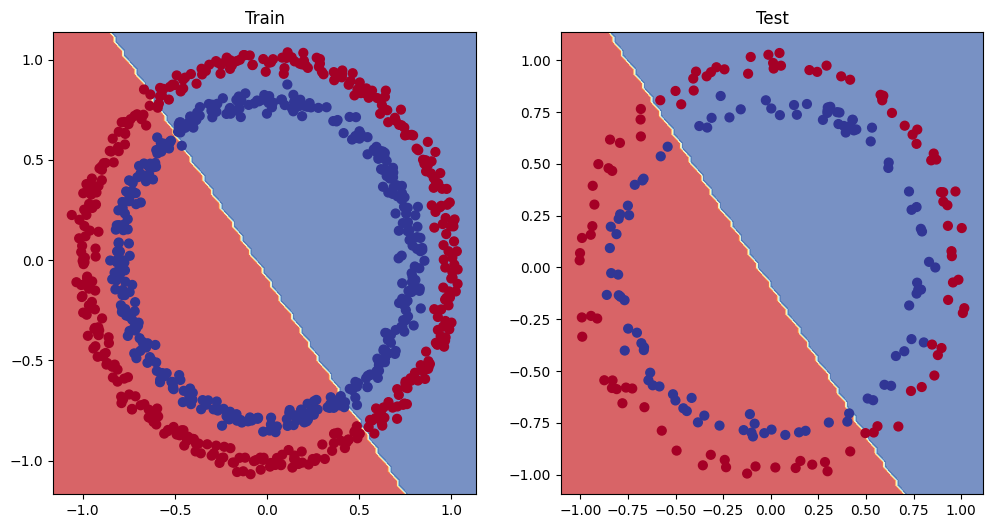

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


Clearly, the model underfits the data and the result is just a random guess.

# Improving the model

## Attempt 1: adding more hidden layers and hidden units

In [33]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):

        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

Train again with `epoch=1000`

In [35]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ## Training ##

    model_1.train()

    # Forward pass
    y_logits =  model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss/accuracy

    # nn.BCEWithLogitsLoss works with logits so we can pass them w/o having to apply sigmoid on them
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Zeroing optimizer
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    optimizer.step()

    ## Testing ##
    model_1.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.69369, Accuracy: 50.25% | Test loss: 0.69270, Test acc: 50.00%
Epoch: 20 | Loss: 0.69351, Accuracy: 50.12% | Test loss: 0.69283, Test acc: 49.50%
Epoch: 30 | Loss: 0.69339, Accuracy: 50.50% | Test loss: 0.69297, Test acc: 48.00%
Epoch: 40 | Loss: 0.69329, Accuracy: 50.38% | Test loss: 0.69310, Test acc: 49.00%
Epoch: 50 | Loss: 0.69322, Accuracy: 49.88% | Test loss: 0.69324, Test acc: 50.00%
Epoch: 60 | Loss: 0.69317, Accuracy: 49.38% | Test loss: 0.69336, Test acc: 51.50%
Epoch: 70 | Loss: 0.69312, Accuracy: 49.38% | Test loss: 0.69348, Test acc: 50.50%
Epoch: 80 | Loss: 0.69309, Accuracy: 50.12% | Test loss: 0.69359, Test acc: 50.00%
Epoch: 90 | Loss: 0.69307, Accuracy: 50.50% | Test loss: 0.69370, Test acc: 48.50%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 110 | Loss: 0.69303, Accuracy: 50.88% | Test loss: 0.69388, Test acc: 46.50%
Epo

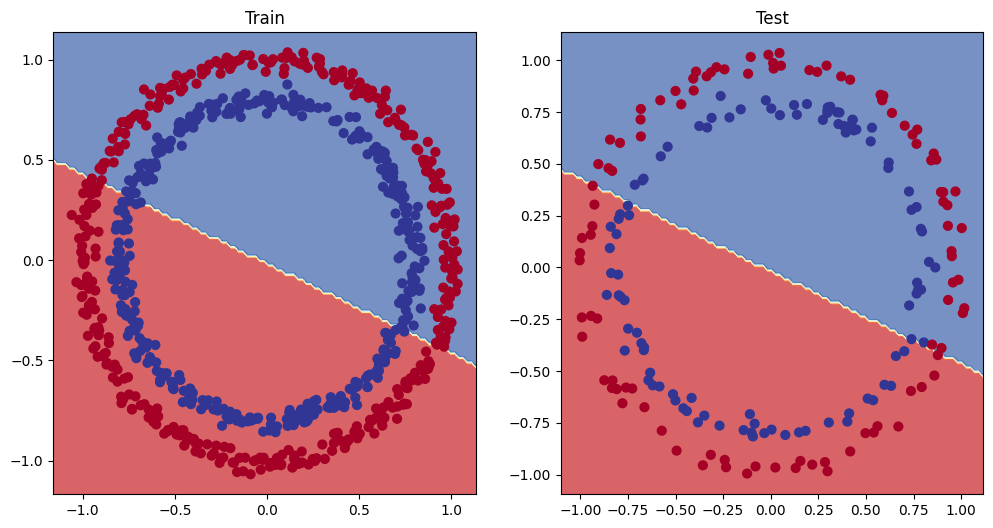

In [36]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Adding more layers and hidden units doesn't work and the model is still making a stright line

### Investigation: is our model capable to train?

Let's check if this underfit model works well with linear data

In [37]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
# split data
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


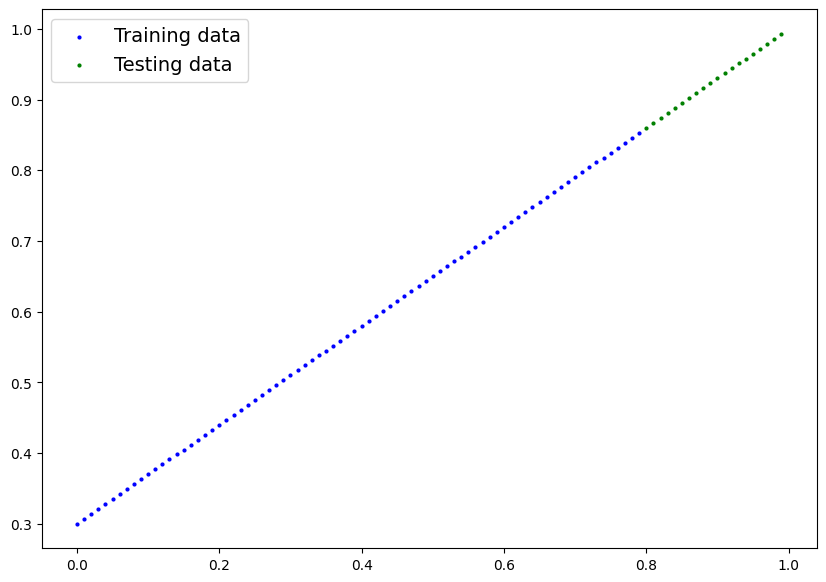

In [41]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [48]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [53]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [55]:
torch.manual_seed(41)

epoch = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()

    # Forward pass
    y_preds = model_2(X_train_regression)

    # Calculate the loss
    loss = loss_fn(y_preds, y_train_regression)

    # Zeroing the grads
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing
    model_2.eval()
    
    with torch.inference_mode():
        # Forward pass
        test_pred = model_2(X_test_regression)

        # Calculate the loss
        test_loss = loss_fn(test_pred, y_test_regression)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Train loss: 0.71306, Test loss: 0.27173
Epoch: 100 | Train loss: 0.16900, Test loss: 0.04551
Epoch: 200 | Train loss: 0.10895, Test loss: 0.04280
Epoch: 300 | Train loss: 0.09240, Test loss: 0.03316
Epoch: 400 | Train loss: 0.07314, Test loss: 0.01136
Epoch: 500 | Train loss: 0.06758, Test loss: 0.02836
Epoch: 600 | Train loss: 0.06096, Test loss: 0.00787
Epoch: 700 | Train loss: 0.06690, Test loss: 0.00728
Epoch: 800 | Train loss: 0.04682, Test loss: 0.02366
Epoch: 900 | Train loss: 0.04752, Test loss: 0.01741


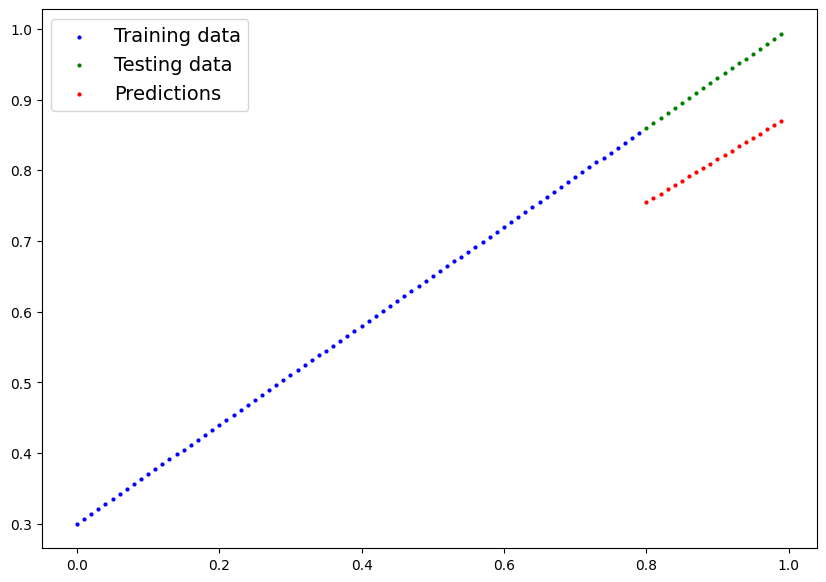

In [56]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

We can see that our model currenlty has a capacity to learn the linear patterns due to the linear activation functions used in the hidden layers

## Attempt 2: Non-linearity
We'll add a non-linear activation to our network

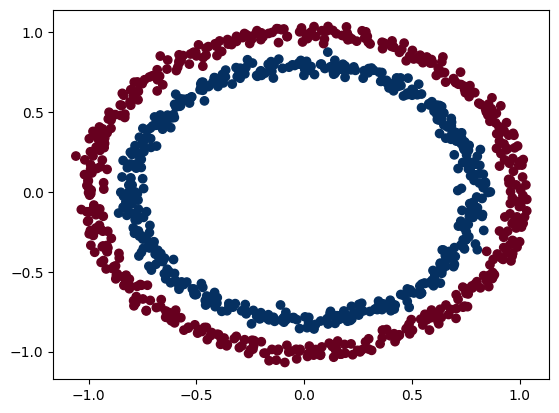

In [61]:
# Make and plot random data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [62]:
import torch
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [97]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        # we can add sigmoid here so we don't need to use in the inference mode
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [98]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [99]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [100]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

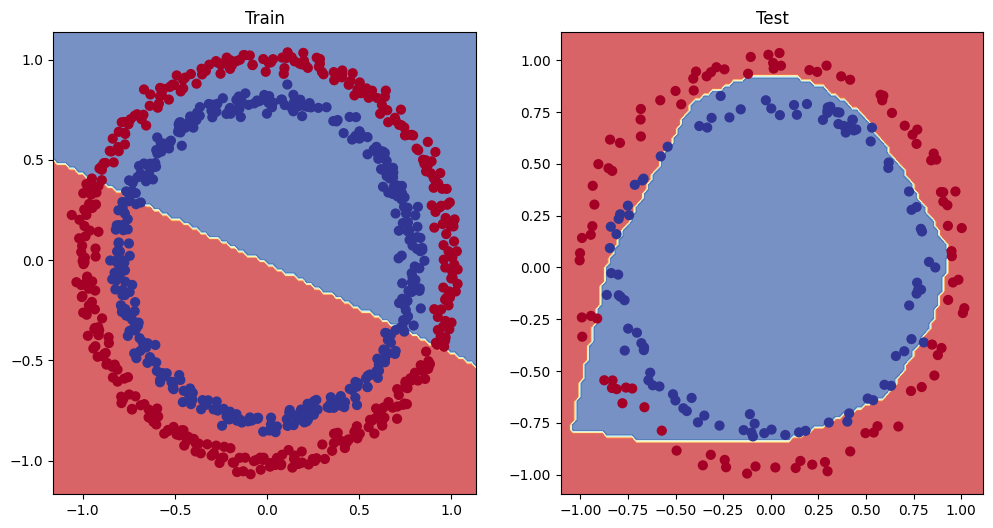

In [101]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Multi-class classification model

## 1. Create random data

tensor([[-8.3001,  6.8316],
        [-5.4696, -6.3115],
        [-5.8188, -6.7357],
        [ 3.7671,  0.3585],
        [ 4.1467, -0.8828]]) tensor([3, 2, 2, 1, 1])


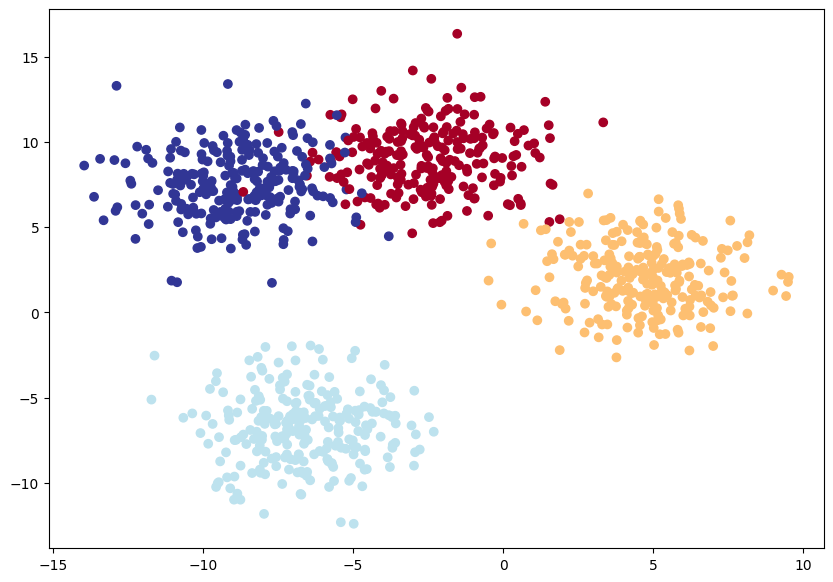

In [80]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2 # xs and ys
RANDOM_SEED = 42

# 1. create random multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    centers=NUM_CLASSES,
    cluster_std=1.9,
    random_state=RANDOM_SEED
)
# 2. convert the data to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. split the data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.1,
    random_state=RANDOM_SEED
)

# 4. plot
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [84]:
from torch import nn


class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        '''
        Args (model's hyperparamters):
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        '''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU,
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [85]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

Let's try looking at the model's output

In [86]:
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.4019, -1.2106,  0.2895,  1.0455],
        [ 0.6825, -1.3423,  0.5798,  1.3673],
        [ 1.0364, -1.4600,  0.9530,  1.7367],
        [ 0.2209, -1.5044,  0.0475,  1.1232],
        [ 2.5071,  0.6950,  2.8854,  1.2802]], device='cuda:0',
       grad_fn=<SliceBackward0>)

These outputs are called *logits*. We need to process it further in order to predict the target class as follows: 

```logits -> prediction probabilities -> prediction labels```

Softmax function (`torch.softmax(...)`) helps us to find the probabilities in the multi-class setting. After having the probabilities calculated, the model must return the highest probability using `torch.argmax()` that returns the index of the class with the highest probability assigned.

In [90]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])
print(torch.argmax(y_pred_probs[0]))

tensor([[-1.2998, -0.9015, -1.5420, -0.5372],
        [ 1.6690, -1.2095,  1.6866,  2.0499],
        [ 2.2173,  0.8077,  2.5821,  0.9654],
        [-0.7227, -0.3456, -0.8255, -0.4981],
        [-0.6088, -1.6484, -0.8880,  0.5736]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1846, 0.2749, 0.1449, 0.3957],
        [0.2827, 0.0159, 0.2877, 0.4137],
        [0.3366, 0.0822, 0.4849, 0.0963],
        [0.2168, 0.3161, 0.1956, 0.2714],
        [0.1862, 0.0658, 0.1408, 0.6072]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor(3, device='cuda:0')


Now, it's time for training

In [91]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04669, Acc: 63.78% | Test Loss: 0.64781, Test Acc: 83.00%
Epoch: 10 | Loss: 0.18201, Acc: 96.89% | Test Loss: 0.17667, Test Acc: 98.00%
Epoch: 20 | Loss: 0.12280, Acc: 96.67% | Test Loss: 0.11429, Test Acc: 98.00%
Epoch: 30 | Loss: 0.10289, Acc: 96.67% | Test Loss: 0.09076, Test Acc: 98.00%
Epoch: 40 | Loss: 0.09353, Acc: 96.67% | Test Loss: 0.07881, Test Acc: 98.00%
Epoch: 50 | Loss: 0.08829, Acc: 96.67% | Test Loss: 0.07175, Test Acc: 98.00%
Epoch: 60 | Loss: 0.08503, Acc: 96.67% | Test Loss: 0.06716, Test Acc: 98.00%
Epoch: 70 | Loss: 0.08284, Acc: 96.67% | Test Loss: 0.06400, Test Acc: 98.00%
Epoch: 80 | Loss: 0.08127, Acc: 96.67% | Test Loss: 0.06171, Test Acc: 98.00%
Epoch: 90 | Loss: 0.08010, Acc: 96.67% | Test Loss: 0.05999, Test Acc: 98.00%


In [92]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  3.8476,   9.2523, -14.5050,  -8.2157],
        [  5.4709, -11.1380,   2.3520,   9.8641],
        [ -4.5218, -11.1005,  19.1377,  10.0020],
        [  1.1072,   6.4176,  -7.1685,  -5.6513],
        [  7.5763,   3.2682, -15.0327,  -2.9653],
        [  6.4023, -14.6151,   4.1246,  12.9360],
        [ -5.2531,  -7.3768,  16.7913,   6.7076],
        [  6.7349,  -1.2709,  -9.2555,   1.0800],
        [ -4.0735, -17.1992,  24.2423,  15.4102],
        [  6.8925,   0.4078, -11.1336,  -0.4135]], device='cuda:0')

In [95]:
# turn predicted logits into prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

# compare the ground truth classes with the predicted classes
print(f"Predictions: {y_preds[:10]}\n Labels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
 Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 98.0%


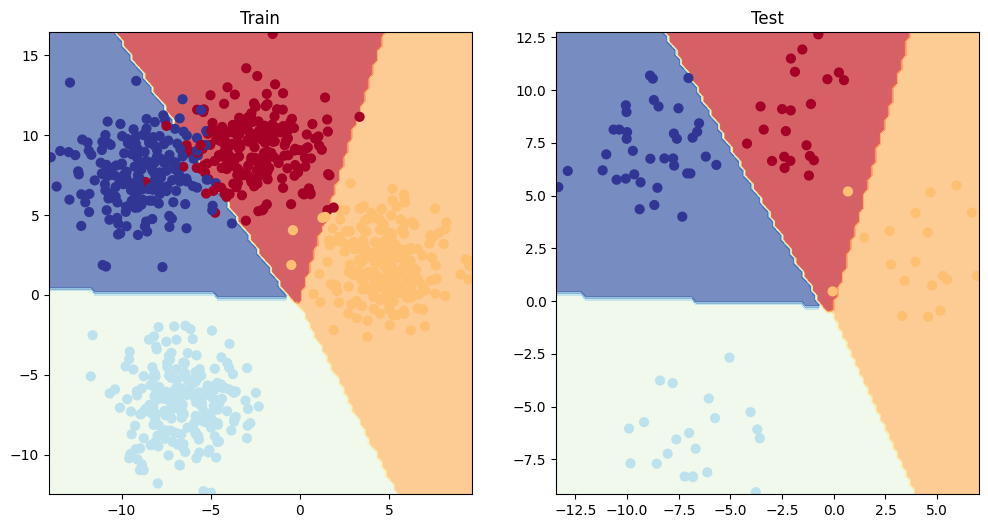

In [96]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
